In [27]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision.io import read_image
import pandas as pd
import numpy as np
import os

In [43]:
pd.read_csv('identity_CelebA.txt').iloc[110:130]

,path label
110,000111.jpg 9474
111,000112.jpg 5950
112,000113.jpg 821
113,000114.jpg 7256
114,000115.jpg 6802
115,000116.jpg 4887
116,000117.jpg 2678
117,000118.jpg 6938
118,000119.jpg 9605
119,000120.jpg 4500


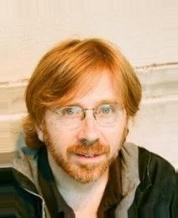

In [44]:
Image.open('data/000119.jpg')

In [45]:
plt.imshow(embedder.mtcnn(Image.open('data/000119.jpg')).int().permute(1,2,0))

NameError: name 'plt' is not defined

In [ ]:
labels = pd.read_csv('identity_CelebA.txt', delimiter=' ')
labels.iloc[40, 0]

'000041.jpg'

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, label_file, img_dir, transform=None):
        self.labels = pd.read_csv(label_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        img = read_image(path)
        label = self.labels.iloc[idx, 1]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [3]:
class Embedder:
    def __init__(self, data=None, batch_size=128):
        if data is None:
            self.data = CustomImageDataset(label_file='cleaned_identities.csv', img_dir='data',transform=transforms.Resize((178,178)))
        else:
            self.data = data
        self.batch_size = batch_size
        self.loader = DataLoader(self.data, batch_size=batch_size, shuffle=False)
        self.mtcnn = MTCNN(select_largest=False, device='cuda', post_process=False, margin=10)
        self.resnet = InceptionResnetV1(pretrained='vggface2', device='cuda',classify=False).eval()

    def get_all_embeddings(self):
        count = 0
        all_embeddings = list()
        all_labels = list()#np.empty(shape=(128,))
       # bad_labels = list()
        for tensors, labels in self.loader:
            if count % 1024 == 0:
                print(count)
            #print(f"label: {labels}")
            faces = self._get_faces(tensors)
            #if faces is None:
                #print(f'bad label! {labels}')
               # bad_labels.append(labels)
           # else:
            #faces = faces.unsqueeze(0)
            embeddings = self.resnet(faces)
            # print(labels.cpu().detach().numpy().shape)
            #  print(f"tensor type: {type(tensors)}")
            # print(f"embedding type: {type(embeddings)}")
            #  print(f"label type: {type(labels)}")
            #  print(f"embeddings shape: {embeddings.cpu().detach().numpy().shape}")
            # print(f"labels shape: {labels.cpu().detach().numpy().shape}")
            all_embeddings.append(embeddings.cpu().detach().numpy())
            all_labels.append(labels.cpu().detach().numpy())
           # all_embeddings = np.hstack([all_embeddings, embeddings.cpu().detach()])
            #all_labels = np.hstack([all_labels, labels.cpu().detach()])
#            all_labels.append(labels)

            count += self.batch_size

           # print(count)
            del faces
            
        return all_embeddings, all_labels
            

    def get_embeddings(self):
        faces, labels = self._get_faces()
        #print(faces)
        embeddings = self.resnet(faces)
        return embeddings, labels

    def _get_faces(self, features):
#        features, labels = next(iter(self.loader))
        #images = [transforms.ToPILImage()(tensor) for tensor in features]
        #print(features.squeeze(0).shape)
        #print(images)
        faces = self.mtcnn(features.permute(0,2,3,1).numpy())
        if faces is None:
            return None
        return torch.stack(faces).cuda()

### Handling Bad Data

Some pictures can't be recognized by mtcnn. When this happens mtcnn returns None (Fun fact this results in the method crashing when trying to batch because when batching it tries to create a numpy array of the bounding boxes, but one of them is none, meaning that the shapes of all the elements in the numpy array are not the same). Since we already have an abundance of data, we just exclude any class that had an unrecognizable face. Based on very rudimentary testing, a miss on mtcnn occurs roughly 3 times per 1000 images, so excluding this data shouldn't be an issue.

In [4]:
embedder = Embedder(batch_size=128)
embeddings, labels = embedder.get_all_embeddings()

0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456
20480
21504
22528
23552
24576
25600
26624
27648
28672
29696
30720
31744
32768
33792
34816
35840
36864
37888
38912
39936


In [7]:
training_embeddings = np.stack(embeddings[:-1]).reshape((-1,512))
training_embeddings = np.vstack([training_embeddings, embeddings[-1]])

In [8]:
training_labels = np.stack(labels[:-1]).reshape((-1,))
training_labels = np.hstack([training_labels, labels[-1]])

In [15]:
print(f"train_X shape: {training_embeddings.shape}")
print(f"train_y shape: {training_labels.shape}")

train_X shape: (40000, 512)
train_y shape: (40000,)


In [16]:
#np.save('train_X.npy', training_embeddings)
#np.save('train_y.npy', training_labels)

In [5]:
test_data = CustomImageDataset('testing_data.csv', img_dir='data', transform=transforms.Resize((178,178)))
test_embedder = Embedder(batch_size=128, data=test_data)

In [6]:
test_embeddings, test_labels = test_embedder.get_all_embeddings()

0
1024
2048
3072
4096
5120
6144
7168
8192
9216
10240
11264
12288
13312
14336
15360
16384
17408
18432
19456


In [10]:
test_X = np.stack(test_embeddings[:-1]).reshape((-1,512))
test_X = np.vstack([test_X, test_embeddings[-1]])

In [12]:
test_y = np.stack(test_labels[:-1]).reshape((-1,))
test_y = np.hstack([test_y, test_labels[-1]])

In [18]:
#np.save('test_X.npy', test_X)
#np.save('test_y.npy', test_y)

### Nearest Neighbor Search in Embedding Space

In [2]:
train_X = np.load('train_X.npy')
train_y = np.load('train_y.npy')

test_X = np.load('test_X.npy')
test_y = np.load('test_y.npy')

In [4]:
from sklearn.neighbors import NearestNeighbors

In [164]:
neighbors = NearestNeighbors(n_neighbors=1000, metric='euclidean')
neighbors = neighbors.fit(train_X)

In [167]:
pred = neighbors.kneighbors(test_X, return_distance=False)

In [74]:
pred.shape

(200, 50)

In [61]:
from sklearn.metrics import accuracy_score

In [165]:
def top_k_accuracy_score(true, pred):
    hits = 0
    total = 0
    for true, pred in zip(true, pred):
        total += 1
        if true in pred:
            nth_neighbor = np.where(pred == true)[0][0]
            hits += 1 #/ nth_neighbor
         #   print('WE FOUND ONE!!!!!')
    return hits/total
 #       print(f"true: {true}")
 #       print(f"pred: {pred}")

In [168]:
top_k_accuracy_score(test_y, pred)

0.0254958951608791

In [137]:
pred[:, 0].shape

(19611,)

In [138]:
accuracy_score(pred[:, 0], test_y)

0.0

In [21]:
test_y[1]

7366

In [44]:
def plot_both(training_csv, testing_csv, training_idx, testing_idx):
    training_img = Image.open('data/' + training_csv.iloc[training_idx]['path'])
    testing_img = Image.open('data/' + testing_csv.iloc[testing_idx]['path'])
    plt.imshow(training_img)
    plt.title(f"Training image, class: {training_csv.iloc[training_idx]['label']}")
    plt.axis('off')
    plt.show()

    plt.imshow(testing_img)
    plt.axis('off')
    plt.title(f"Testing image, class: {testing_csv.iloc[testing_idx]['label']}")
    plt.show()

In [34]:
raw_training_data = pd.read_csv('cleaned_identities.csv')
raw_testing_data = pd.read_csv('testing_data.csv')

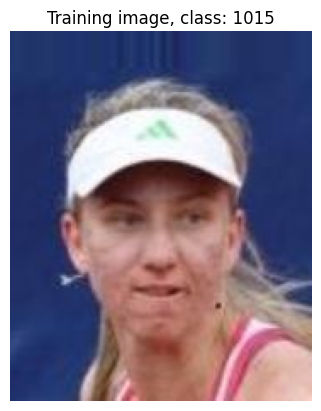

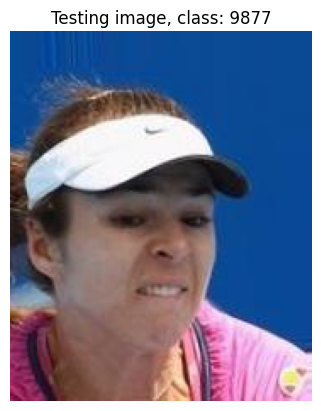

In [163]:
idx = 11
plot_both(raw_training_data, raw_testing_data, pred[idx][0], idx)

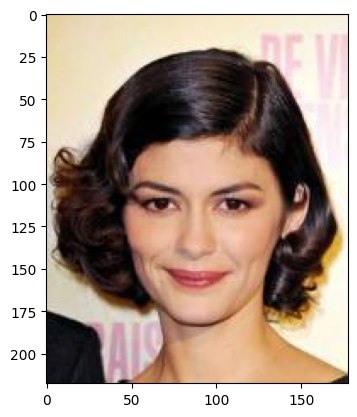

In [29]:
raw_training_data = pd.read_csv('cleaned_identities.csv')
plt.imshow(Image.open('data/'+raw_training_data.iloc[38793]['path']))

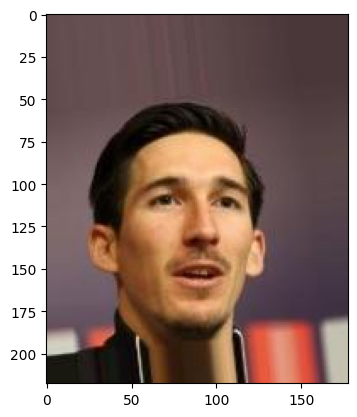

In [32]:
raw_testing_data = pd.read_csv('testing_data.csv')
plt.imshow(Image.open('data/' + raw_testing_data.iloc[0]['path']))

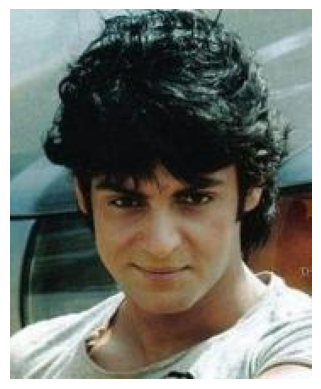

In [173]:
example_img = Image.open('data/002304.jpg')
plt.imshow(example_img)
plt.axis('off')
plt.show()

In [182]:
train_X[2303].shape

(512,)

In [175]:
mtcnn = MTCNN(select_largest=False, device='cuda', post_process=False, margin=10)

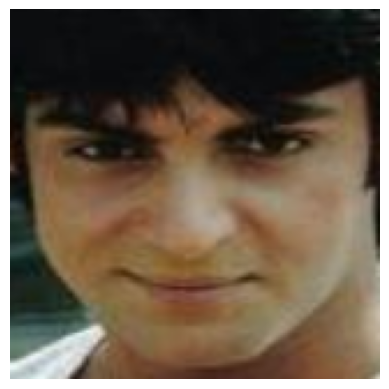

In [179]:
plt.imshow(mtcnn(example_img).permute(1,2,0).int())
plt.axis('off')
plt.show()